**Installs**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Imports**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import vgg11

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import copy

#NUM_CLASSES = 102
NUM_CLASSES = 5
DEVICE = 'cuda'
MOMENTUM = 0.9

**Model definition**

In [0]:
def get_datasets(train_data_dir, test_data_dir, compose=[transforms.Resize(224),
                                                         transforms.CenterCrop(224),
                                                         transforms.ToTensor()
                                                         ]):
    train_transform = transforms.Compose(compose)
    eval_transform = transforms.Compose([
          #transforms.Resize(224),
          transforms.CenterCrop(224),
          transforms.ToTensor()#,
          #transforms.Normalize((45.6068733, 0.81077038, 57.85301916), (66.92374056, 9.88349788, 49.96761776))
          ])

    '''
    if not os.path.isdir('./Homework2-Caltech101'):
        !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

    '''
    if not os.path.isdir('./AIML_project'):
        !git clone https://github.com/anphetamina/AIML_project.git
    
    train_dataset = torchvision.datasets.ImageFolder(train_data_dir, transform=train_transform)
    test_dataset = torchvision.datasets.ImageFolder(test_data_dir, transform=eval_transform)

    return train_dataset, test_dataset

def test_network(net, test_dataset, batch_size):
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    net.train(False)

    criterion = nn.CrossEntropyLoss()

    sum_test_losses = 0.0
    running_corrects = 0
    for images, labels in test_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      test_loss = criterion(outputs, labels)
      sum_test_losses += test_loss.item()*images.size(0)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataset))

    # Calculate loss
    test_loss = sum_test_losses / float(len(test_dataset))

    return accuracy, test_loss

def train_network(net, parameters_to_optimize, learning_rate, num_epochs, batch_size, weight_decay, step_size, gamma, train_dataset, val_dataset=None, verbosity=False, plot=False):
  
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(parameters_to_optimize, lr=learning_rate, momentum=MOMENTUM, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    net = net.to(DEVICE)
    best_net = vgg11()
    best_net = best_net.to(DEVICE)
    best_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    cudnn.benchmark

    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    current_step = 0
    best_val_accuracy = 0.0
    best_val_loss = 0.0
    for epoch in range(num_epochs):

        train_running_corrects = 0
        sum_train_losses = 0.0

        for images, labels in train_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            net.train()
            optimizer.zero_grad()

            outputs = net(images)
            _, preds = torch.max(outputs.data, 1)
            train_running_corrects += torch.sum(preds == labels.data).data.item()
            loss = criterion(outputs, labels)
            sum_train_losses += loss.item()*images.size(0)
            loss.backward()

            optimizer.step()
            current_step += 1
        
        # Calculate accuracy on train set
        train_accuracy = train_running_corrects / float(len(train_dataset))
        train_accuracies.append(train_accuracy)

        if val_dataset is not None:
            val_accuracy, val_loss = test_network(net, val_dataset, batch_size)
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_val_loss = val_loss
                best_net.load_state_dict(net.state_dict())
            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss)
            #acc_diff = train_accuracy-val_accuracy
            #if acc_diff > 0.25:
              #print("overfit -> train_accuracy {}, val_accuracy {}".format(train_accuracy, val_accuracy))
              #return best_net, best_val_accuracy, best_val_loss

        

        # Calculate loss on training set
        train_loss = sum_train_losses/float(len(train_dataset))
        train_losses.append(loss)

        if verbosity:
            if val_dataset is not None:
                print("train_acc: {}, val_acc: {}, train_loss: {}, val_loss: {} ({} / {})".format(train_accuracy, val_accuracy, train_loss, val_loss, epoch+1, num_epochs))
            else:
                print("train_acc: {}, train_loss: {} ({} / {})".format(train_accuracy, train_loss, epoch+1, num_epochs))
        

        if train_accuracy < 0.25 and epoch > num_epochs*0.1 or train_accuracy < 0.35 and epoch > num_epochs*0.5:
          print("underfit -> train_accuracy = {}".format(train_accuracy))
          return best_net, best_val_accuracy, best_val_loss

        scheduler.step()

    if plot:

        fig, ax = plt.subplots()
        line1, = ax.plot(train_losses, label='Loss on training set')
        line2, = ax.plot(train_accuracies, label='Accuracy on training set')
        ax.legend()
        plt.xlabel("Epochs")
        plt.show()

        if val_dataset is not None:
            fig, ax = plt.subplots()
            line1, = ax.plot(val_accuracies, label='Accuracy on validation set', color='C2')
            line2, = ax.plot(train_accuracies, label='Accuracy on training set', color='C3')
            ax.legend()
            plt.xlabel("Epochs")
            plt.show()
        
            fig, ax = plt.subplots()
            line1, = ax.plot(val_losses, label='Loss on validation set', color='C1')
            line2, = ax.plot(train_losses, label='Loss on training set', color='C7')
            ax.legend()
            plt.xlabel("Epochs")
            plt.show()

    
    return best_net, best_val_accuracy, best_val_loss


**Train + validation**

training set 745
validation set 83
train_acc: 0.23221476510067113, val_acc: 0.3855421686746988, train_loss: 1.6004910485056423, val_loss: 1.5808396784656018 (1 / 100)
train_acc: 0.24563758389261744, val_acc: 0.3493975903614458, train_loss: 1.576837316775482, val_loss: 1.5616827011108398 (2 / 100)
train_acc: 0.28053691275167786, val_acc: 0.24096385542168675, train_loss: 1.5653064606173726, val_loss: 1.5495410855994167 (3 / 100)
train_acc: 0.2966442953020134, val_acc: 0.26506024096385544, train_loss: 1.5495984461483538, val_loss: 1.5110053168721946 (4 / 100)
train_acc: 0.33557046979865773, val_acc: 0.40963855421686746, train_loss: 1.497584098137465, val_loss: 1.4164257365536976 (5 / 100)
train_acc: 0.3610738255033557, val_acc: 0.3855421686746988, train_loss: 1.4401303955372549, val_loss: 1.3749975971428745 (6 / 100)
train_acc: 0.3610738255033557, val_acc: 0.37349397590361444, train_loss: 1.352284965339123, val_loss: 1.2897028808134148 (7 / 100)
train_acc: 0.3932885906040268, val_acc: 0.4

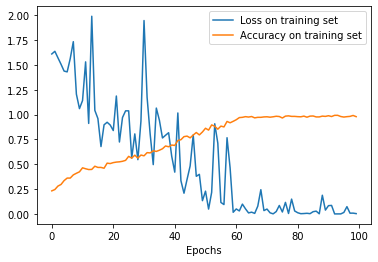

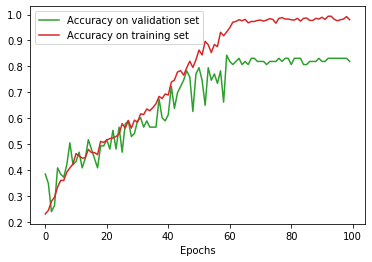

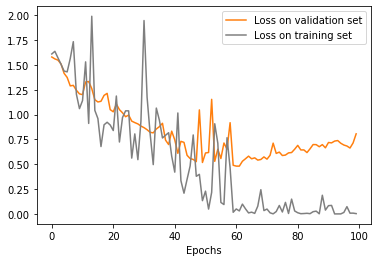

val accuracy 0.8433734939759037
val loss 0.489986171833722


In [3]:
# lr 0.0006444500508054211, batch 14, decay 2.1280582227123365e-05, gamma 0.19924404264743992, val accuracy 0.6305418719211823, val loss 1.0403618915327664 [5 / 50]
# lr 0.00038041059192815333, batch 9, decay 3.8372561126798785e-05, gamma 0.057680309789029396, val accuracy 0.6108374384236454, val loss 0.9877617955207825 [38 / 50]
# lr 0.00043660847130590896, batch 10, decay 0.00025031720443271155, gamma 0.011678955740792939, val accuracy 0.5615763546798029, val loss 1.0453474251507537 [43 / 50]
# lr 0.00027531434783290124, batch 9, decay 4.3783604017624755e-06, gamma 0.11844128056704877, val accuracy 0.5517241379310345, val loss 1.117455956383879 [44 / 50]
# lr 0.0007220498435995008, batch 14, decay 2.228552014354877e-05, gamma 0.08113961287843949, val accuracy 0.625615763546798, val loss 0.9968108699239534 [49 / 50]
# lr 0.0008377019231346562, batch 8, decay 2.4427015675775187e-06, gamma 0.00903130010323455, val accuracy 0.5849802371541502, val loss 1.0701400147596367 [1 / 50]
# lr 0.0010316163585472981, batch 8, decay 1.8309942558988887e-05, gamma 0.002673690056313373, val accuracy 0.5592885375494071, val loss 1.0480610431418589 [5 / 50]
# lr 0.0016661746592012004, batch 8, decay 3.3763075569909223e-06, gamma 0.006052773438030023, val accuracy 0.6067193675889329, val loss 1.0441360360548901 [6 / 50]
# lr 0.0005075392266021225, batch 12, decay 0.00015097107216674634, gamma 0.23307879269069465, val accuracy 0.6650246305418719, val loss 1.0321336309310838 [12 / 50]
# lr 0.0005293020727186627, batch 11, decay 0.0001569197221403604, gamma 0.0797979883084818, val accuracy 0.6059113300492611, val loss 1.0818345975406065 [13 / 50]
# lr 0.0008554266290399184, batch 11, decay 0.0006533010900552039, gamma 0.06721270304757815, val accuracy 0.7941176470588235, val loss 0.9317472677897004 [18 / 50]
BATCH_SIZE = 11
LR = 0.0008554266290399184
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0006533010900552039
NUM_EPOCHS = 100
STEP_SIZE = 60
GAMMA = 0.06721270304757815


TRAIN_DATA_DIR = 'AIML_project/ravdess-emotional-song-spec-224'
#TRAIN_DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'
compose=[#transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.RandomGrayscale(),
         transforms.ColorJitter(brightness=0.5, contrast=0.5),
         transforms.ToTensor()
         ]
train_dataset, val_dataset = get_datasets(TRAIN_DATA_DIR, TRAIN_DATA_DIR, compose)
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 10]
val_indexes = [idx for idx in range(len(train_dataset)) if not idx % 10]
val_dataset = Subset(val_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)
print('training set {}'.format(len(train_dataset)))
print('validation set {}'.format(len(val_dataset)))

net = vgg11()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
best_net, val_accuracy, val_loss = train_network(net, net.parameters(), LR, NUM_EPOCHS, BATCH_SIZE, WEIGHT_DECAY, STEP_SIZE, GAMMA, train_dataset, val_dataset=val_dataset, verbosity=True, plot=True)

print('val accuracy {}'.format(val_accuracy))
print('val loss {}'.format(val_loss))

**Testing**

In [4]:
from torchvision import datasets
# Serve per il mapping fra label sul file con le labels per canzone di test e l'indice della label che la rete considera.
LABELS_FROM_FILE = {'angry' : 0, 'calming' : 1, 'happy' : 2, 'normal' : 3, 'sad' : 4}
NUM_CLASSES = 5
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

def test_network_with_songs_data_return(net, test_dataset, batch_size):
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    net.train(False)
    net = net.to(DEVICE)

    test_songs_data = dict()
    for images, labels, paths in test_dataloader:
      torch.cuda.empty_cache()
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      idx = 0;
      for pred in preds:

        image_name = paths[idx].split("/")[-1]
        song_idx = image_name.split("_")[0]
      
        if song_idx not in test_songs_data:
          test_songs_data[song_idx] = dict()
          test_songs_data[song_idx]["preds"] = np.zeros(NUM_CLASSES, dtype=int)
          # test_songs_data[song_idx]["outputs"] = []

        test_songs_data[song_idx]["preds"][pred] += 1
        # test_songs_data[song_idx]["outputs"].append(outputs[idx])

        idx += 1

      del labels
      del images
      del outputs

    return test_songs_data

def read_songs_labels(path):
  f = open(path,"r")
  lines = f.readlines()

  song_labels = dict()

  for line in lines:
    names = line.split(":")

    if names[0] not in song_labels:
      song_labels[names[0]] = []

    labels = names[1].replace(" ", "").split(",")
    labels[-1] = labels[-1][:-2]

    for label in labels:
      song_labels[names[0]].append(LABELS_FROM_FILE[label])
  
  return song_labels

def major_voting_analyze(songs_data, songs_labels):

  ordered_keys = sorted(songs_labels.keys())
  print(ordered_keys)
  prediction = dict()
  avg_outputs = dict()
  corrects = 0

  for key in songs_data.keys():
    num_slices = 0
    for value in songs_data[key]["preds"]:
      num_slices += value


    for value in songs_data[key]["preds"]:
      value = (float) (value/num_slices)
      # if value > 0.5:
      #   prediction[key] = idx_pred

    max = 0
    idx_pred = 0
    idx_max = 0
    for value in songs_data[key]["preds"]:
      if value > max:
        max = value
        idx_max = idx_pred
      idx_pred += 1

    prediction[key] = idx_max

    # for output in songs_data[key]["outputs"]:
    #   if sum_outputs is None:
    #     sum_outputs = output
    #   else:
    #     sum_outputs += output

    # avg_ouputs = sum_outputs/num_slices

  idx = 0
  keys = sorted(prediction.keys(), key=int)
  print(list(keys))
  for song_idx in keys:
    if prediction[song_idx] in songs_labels[ordered_keys[idx]]:
      corrects += 1
    print("Prediction for song {} - {}: {}; labels: {}".format(song_idx, ordered_keys[idx], prediction[song_idx], list(songs_labels[ordered_keys[idx]])))
    idx += 1

  test_accuracy = (float) (corrects / idx)
  print("Test accuracy: {}".format(test_accuracy))

def get_test_dataset(test_data_dir):
    eval_transform = transforms.Compose([
          #transforms.Resize(224),
          transforms.CenterCrop(224),
          transforms.ToTensor()
          ])
    
    if not os.path.isdir('./AIML_project'):
        !git clone https://github.com/anphetamina/AIML_project.git
    
    test_dataset = ImageFolderWithPaths(test_data_dir, transform=eval_transform)

    return test_dataset

torch.cuda.empty_cache()

TEST_DATA_DIR = 'AIML_project/CAL500_test_sliced_spectrograms'
test_dataset = get_test_dataset(TEST_DATA_DIR)
print('test set {}'.format(len(test_dataset)))

# net extracted by training
songs_data = test_network_with_songs_data_return(best_net, test_dataset, BATCH_SIZE)

print(songs_data)

songs_labels = read_songs_labels("AIML_project/songs_filtered_with_labels.txt")

print(songs_labels)

major_voting_analyze(songs_data, songs_labels)

test set 19229
{'100': {'preds': array([ 0,  0, 49,  0,  0])}, '101': {'preds': array([ 1,  0, 60,  0,  0])}, '102': {'preds': array([ 0,  0, 38,  0,  0])}, '103': {'preds': array([ 0,  0, 42,  0,  0])}, '104': {'preds': array([ 0,  0, 36,  0,  0])}, '105': {'preds': array([ 0,  2, 85,  1,  6])}, '106': {'preds': array([ 0,  0, 46,  0,  0])}, '107': {'preds': array([ 0,  0, 24,  0,  0])}, '108': {'preds': array([ 0,  0, 64,  0,  0])}, '109': {'preds': array([ 0,  0, 54,  1,  0])}, '10': {'preds': array([ 0,  0, 66,  0,  4])}, '110': {'preds': array([ 0,  0, 29,  0,  0])}, '111': {'preds': array([ 0,  0, 28,  0,  0])}, '112': {'preds': array([ 0,  0, 42,  0,  0])}, '113': {'preds': array([ 1, 10, 54,  1, 26])}, '114': {'preds': array([ 0,  0, 55,  0,  0])}, '115': {'preds': array([ 0,  0, 30,  0,  0])}, '116': {'preds': array([ 0,  0, 49,  0,  0])}, '117': {'preds': array([ 0,  0, 42,  1,  0])}, '118': {'preds': array([ 0,  0, 52,  0,  0])}, '119': {'preds': array([ 1,  0, 38,  0,  0])}

**Random search**

In [5]:
# best scores
# 
best_accuracy = 0.0
best_loss = 0.0
val_accuracies = []
val_losses = []
import random
TRAIN_DATA_DIR = 'AIML_project/ravdess-emotional-song-spec-672'
#TRAIN_DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'
compose=[transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomGrayscale(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5),
        transforms.ToTensor()
        ]
train_dataset, val_dataset = get_datasets(TRAIN_DATA_DIR, TRAIN_DATA_DIR, compose)
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 10]
val_indexes = [idx for idx in range(len(train_dataset)) if not idx % 10]
val_dataset = Subset(val_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)
print('training set {}'.format(len(train_dataset)))
print('validation set {}'.format(len(val_dataset)))
best_net = vgg11()
best_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
best_net = best_net.to(DEVICE)
best_set = {}
N = 50
for i in range(N):
  BATCH_SIZE = int(random.uniform(8, 16))
  LR = 10**random.uniform(-5, -3)
  MOMENTUM = 0.9
  WEIGHT_DECAY = 10**random.uniform(-6, -3)
  NUM_EPOCHS = 80
  STEP_SIZE = 48
  GAMMA = 10**random.uniform(-2, 0)
  set = {"lr": LR, "batch_size": BATCH_SIZE, "weight_decay": WEIGHT_DECAY, "gamma": GAMMA}
  print("-------------------------------------")
  print(set)
  net = vgg11()
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  current_net, val_accuracy, val_loss = train_network(net, net.parameters(), LR, NUM_EPOCHS, BATCH_SIZE, WEIGHT_DECAY, STEP_SIZE, GAMMA, train_dataset, val_dataset=val_dataset, verbosity=True)

  val_accuracies.append(val_accuracy)
  val_losses.append(val_loss)

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_loss = val_loss
    best_net = copy.deepcopy(current_net)
    best_set = copy.deepcopy(set)

  print("lr {}, batch {}, decay {}, gamma {}, val accuracy {}, val loss {} [{} / {}]".format(LR, BATCH_SIZE, WEIGHT_DECAY, GAMMA, val_accuracy, val_loss, i+1, N))

print("--------------------------------------------")
print("\n{}, best val accuracy {}, best val loss {}".format(best_set, best_accuracy, best_loss))
print("val accuracies\n{}".format(val_accuracies))
print("val losses\n{}".format(val_losses))

training set 910
validation set 102
-------------------------------------
{'lr': 2.3170275303150695e-05, 'batch_size': 11, 'weight_decay': 0.00012271015129769862, 'gamma': 0.016100234551165854}
train_acc: 0.16153846153846155, val_acc: 0.17647058823529413, train_loss: 1.7928433832231458, val_loss: 1.7922614497296951 (1 / 80)
train_acc: 0.16373626373626374, val_acc: 0.17647058823529413, train_loss: 1.7919728057725088, val_loss: 1.791697705493254 (2 / 80)
train_acc: 0.17472527472527472, val_acc: 0.17647058823529413, train_loss: 1.7917875389476399, val_loss: 1.7911660834854723 (3 / 80)
train_acc: 0.18461538461538463, val_acc: 0.17647058823529413, train_loss: 1.7909264036587307, val_loss: 1.790641801030028 (4 / 80)
train_acc: 0.18461538461538463, val_acc: 0.17647058823529413, train_loss: 1.791339478125939, val_loss: 1.790124255068162 (5 / 80)
train_acc: 0.1813186813186813, val_acc: 0.17647058823529413, train_loss: 1.79077926834861, val_loss: 1.7896123855721717 (6 / 80)
train_acc: 0.19780219

KeyboardInterrupt: ignored

**Grid search**

In [0]:
NUM_CLASSES = 6
DEVICE = 'cuda'
#BATCH_SIZE = 16
#LR = 0.001
MOMENTUM = 0.9
#WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 100
STEP_SIZE = 60
#GAMMA = 0.1
'''
lr_range = [0.005, 0.001, 0.0005]
batch_size_range = [16, 8]
weight_decay_range = [5e-5, 5e-3]
gamma_range = [0.1, 0.01]
hyperparameters_sets = []

for lr in lr_range:
  for batch_size in batch_size_range:
    for weight_decay in weight_decay_range:
      for gamma in gamma_range:
        hyperparameters_sets.append({'lr': lr, 'batch_size': batch_size, 'weight_decay': weight_decay, 'gamma': gamma})
'''

# lr 0.0006444500508054211, batch 14, decay 2.1280582227123365e-05, gamma 0.19924404264743992, val accuracy 0.6305418719211823, val loss 1.0403618915327664 [5 / 50]
# lr 0.00038041059192815333, batch 9, decay 3.8372561126798785e-05, gamma 0.057680309789029396, val accuracy 0.6108374384236454, val loss 0.9877617955207825 [38 / 50]
# lr 0.00043660847130590896, batch 10, decay 0.00025031720443271155, gamma 0.011678955740792939, val accuracy 0.5615763546798029, val loss 1.0453474251507537 [43 / 50]
# lr 0.00027531434783290124, batch 9, decay 4.3783604017624755e-06, gamma 0.11844128056704877, val accuracy 0.5517241379310345, val loss 1.117455956383879 [44 / 50]
# lr 0.0007220498435995008, batch 14, decay 2.228552014354877e-05, gamma 0.08113961287843949, val accuracy 0.625615763546798, val loss 0.9968108699239534 [49 / 50]
# lr 0.0008377019231346562, batch 8, decay 2.4427015675775187e-06, gamma 0.00903130010323455, val accuracy 0.5849802371541502, val loss 1.0701400147596367 [1 / 50]
# lr 0.0010316163585472981, batch 8, decay 1.8309942558988887e-05, gamma 0.002673690056313373, val accuracy 0.5592885375494071, val loss 1.0480610431418589 [5 / 50]
# lr 0.0016661746592012004, batch 8, decay 3.3763075569909223e-06, gamma 0.006052773438030023, val accuracy 0.6067193675889329, val loss 1.0441360360548901 [6 / 50]

hyperparameters_sets = []
lr_list = [0.0006444500508054211, 0.00038041059192815333, 0.00043660847130590896, 0.00027531434783290124, 0.0007220498435995008, 0.0008377019231346562, 0.0010316163585472981, 0.0016661746592012004]
bs_list = [14, 9, 10, 9, 14, 8, 8, 8]
wd_list = [2.1280582227123365e-05, 3.8372561126798785e-05, 0.00025031720443271155, 4.3783604017624755e-06, 2.228552014354877e-05, 2.4427015675775187e-06, 1.8309942558988887e-05, 3.3763075569909223e-06]
g_list = [0.19924404264743992, 0.057680309789029396, 0.011678955740792939, 0.11844128056704877, 0.08113961287843949, 0.00903130010323455, 0.002673690056313373, 0.006052773438030023]

for i in range(8):
  set = {"lr": lr_list[i], "batch_size": bs_list[i], "weight_decay": wd_list[i], "gamma": g_list[i]}
  hyperparameters_sets.append(set)

for set in hyperparameters_sets:
  print(set)


TRAIN_DATA_DIR = 'AIML_project/ravdess-emotional-song-spec-672'
compose=[transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.RandomGrayscale(),
         transforms.ColorJitter(brightness=0.5, contrast=0.5),
         transforms.ToTensor()
         ]
train_dataset, val_dataset = get_datasets(TRAIN_DATA_DIR, TRAIN_DATA_DIR, compose)

train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
val_indexes = [idx for idx in range(len(train_dataset)) if not idx % 5]
val_dataset = Subset(val_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)
print('training set {}'.format(len(train_dataset)))
print('validation set {}'.format(len(val_dataset)))

best_net = vgg11()
best_net = best_net.to(DEVICE)
best_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
best_set = {}
best_accuracy = 0.0
best_loss = 0.0
val_accuracies = []
val_losses = []
n = 0
for set in hyperparameters_sets:

  net = vgg11()
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  current_net, val_accuracy, val_loss = train_network(net, net.parameters(), set['lr'], NUM_EPOCHS, set['batch_size'], set['weight_decay'], STEP_SIZE, set['gamma'], train_dataset, val_dataset=val_dataset, verbosity=True)
  val_accuracies.append(val_accuracy)
  val_losses.append(val_loss)

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_loss = val_loss
    best_net = copy.deepcopy(current_net)
    best_set = copy.deepcopy(set)
  n += 1
  print("({}), val accuracy {}, val loss {} [{} / {}]".format(set, val_accuracy, val_loss, n, len(hyperparameters_sets)))

print("\n\n({}), best val accuracy {}, best val loss {}\n".format(best_set, best_accuracy, best_loss))
print("\nval_accuracies")
print(val_accuracies)

{'lr': 0.0006444500508054211, 'batch_size': 14, 'weight_decay': 2.1280582227123365e-05, 'gamma': 0.19924404264743992}
{'lr': 0.00038041059192815333, 'batch_size': 9, 'weight_decay': 3.8372561126798785e-05, 'gamma': 0.057680309789029396}
{'lr': 0.00043660847130590896, 'batch_size': 10, 'weight_decay': 0.00025031720443271155, 'gamma': 0.011678955740792939}
{'lr': 0.00027531434783290124, 'batch_size': 9, 'weight_decay': 4.3783604017624755e-06, 'gamma': 0.11844128056704877}
{'lr': 0.0007220498435995008, 'batch_size': 14, 'weight_decay': 2.228552014354877e-05, 'gamma': 0.08113961287843949}
{'lr': 0.0008377019231346562, 'batch_size': 8, 'weight_decay': 2.4427015675775187e-06, 'gamma': 0.00903130010323455}
{'lr': 0.0010316163585472981, 'batch_size': 8, 'weight_decay': 1.8309942558988887e-05, 'gamma': 0.002673690056313373}
{'lr': 0.0016661746592012004, 'batch_size': 8, 'weight_decay': 3.3763075569909223e-06, 'gamma': 0.006052773438030023}
training set 809
validation set 203
train_acc: 0.173053

**Testing**

In [0]:
# todo

**Mean / std computation**

In [0]:
TRAIN_DATA_DIR = 'AIML_project/ravdess-emotional-song-spec-672'
pixel_mean = np.zeros(3)
pixel_std = np.zeros(3)
k = 1
dataset, _ = get_datasets(TRAIN_DATA_DIR, TRAIN_DATA_DIR, [])
for image, _ in tqdm(dataset, "Computing mean/std", len(dataset), unit="samples"):
    image = np.array(image)
    pixels = image.reshape((-1, image.shape[2]))

    for pixel in pixels:
        diff = pixel - pixel_mean
        pixel_mean += diff / k
        pixel_std += diff * (pixel - pixel_mean)
        k += 1

pixel_std = np.sqrt(pixel_std / (k - 2))
print(pixel_mean)
print(pixel_std)

Cloning into 'AIML_project'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 24421 (delta 28), reused 33 (delta 14), pack-reused 24373
Receiving objects: 100% (24421/24421), 2.15 GiB | 48.26 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Checking out files: 100% (24638/24638), done.


Computing mean/std: 100%|██████████| 1012/1012 [47:31<00:00,  2.82s/samples]

[45.6068733   0.81077038 57.85301916]
[66.92374056  9.88349788 49.96761776]
